In [27]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import scipy
import random
import cmath
#import pylops # might not need
import math
import pyproximal

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model
from tensorflow.keras.saving import register_keras_serializable, deserialize_keras_object
from tensorflow.test import compute_gradient
from tensorflow.compat.v1 import assign_sub

from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft, ifft, fft2, ifft2
from scipy.optimize import minimize

import autosetup 
from backpropagation import CBP, CBP_decoder
from complex_optimizer import Complex_SGD, adaptive_stepsize

In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


Some nice tensorflow links
https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing#putting_it_all_together_an_end-to-end_example 
https://www.tensorflow.org/guide/keras/functional_api
https://www.tensorflow.org/api_docs/python/tf/keras/Layer#used-in-the-notebooks
https://www.tensorflow.org/api_docs/python/tf/keras/Layer#call

## Autoencoder

### Dataset

In [3]:
# code from: https://www.tensorflow.org/tutorials/generative/autoencoder

In [4]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255. #normalize the data
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

# make a smaller training set
x_train_temp = x_train[..., tf.newaxis]
x_train_temp = tf.image.resize(x_train_temp, [10,10])
x_train_small = x_train_temp[:,:,:,0]

x_test_temp = x_test[..., tf.newaxis]
x_test_temp = tf.image.resize(x_test_temp, [10,10])
x_test_small = x_test_temp[:,:,:,0]

#x_train_small = tf.image.resize(x_train, [10, 10])
#x_test_small = tf.image.resize(x_test, [10, 10])

print(x_train_small.shape)
print(x_test_small.shape)

# make a complex (smaller) training set
x_train_cx_small = tf.complex(np.ones((x_train_small.shape)).astype('float32'), x_train_small)
x_test_cx_small = tf.complex(np.ones((x_test_small.shape)).astype('float32'), x_test_small)

# make the training set smaller for testing code
x_train_cx_reduced = x_train_cx_small[0:10000, :, :]

print(x_train_cx_small.shape)
print(type(x_train_cx_small))

print(x_train_cx_reduced.shape[0])

(60000, 28, 28)
(10000, 28, 28)
(60000, 10, 10)
(10000, 10, 10)
(60000, 10, 10)
<class 'tensorflow.python.framework.ops.EagerTensor'>
10000


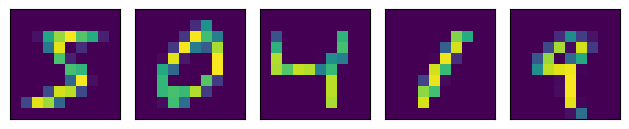

In [5]:
# representation training dataset (real case)
ns = 5
fig, ax = plt.subplots(1,ns)

for i in range(ns):
    x = x_train_small[i]
    ax[i].imshow(np.real(x).reshape((10,10)),clim=[0,1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.tight_layout()

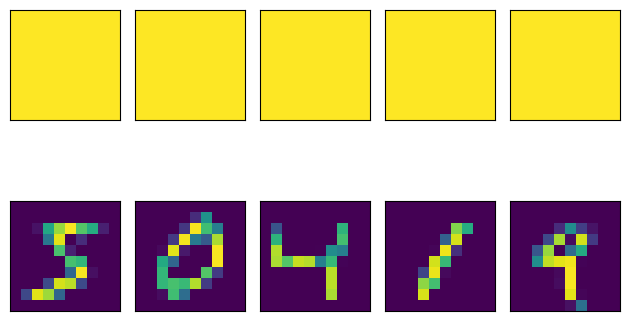

In [6]:
ns = 5
fig, ax = plt.subplots(2,ns)

for i in range(ns):
    x = x_train_cx_small[i]
    ax[0,i].imshow(np.real(x).reshape((10,10)),clim=[0,1], cmap= 'viridis')
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((10,10)),clim=[0,1], cmap='viridis')
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()


### Training loop

In [7]:
# wrapper for training
@tf.function
def train_step(x, alpha, encoder, decoder, optimizer):
    y = decoder(encoder(x))
    loss_value = autosetup.loss_MSE(y, x)
    grads_and_vars = CBP(x, y, encoder, decoder, autosetup.dLossdaL, autosetup.Jac_modrelu)
    new_alpha = adaptive_stepsize(x, y, alpha, encoder, decoder, autosetup.loss_MSE, grads_and_vars)
    _ = optimizer.apply_gradients(grads_and_vars, alpha = alpha)
    return loss_value, new_alpha

In [8]:
# ref: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

# parameters (might move somewhere else)
EPOCHS = 2
dataset = x_train_cx_reduced
dataset_size = dataset.shape[0]
reshape_dataset = tf.reshape(dataset, (dataset_size,-1))
sample_shape = reshape_dataset.shape[-1]
print(dataset_size)
print(sample_shape)
#train_dataset = tf.data.Dataset.from_tensor_slices(reshape_dataset).batch(1)

train_dataset = (
    tf.data.Dataset.from_tensor_slices(reshape_dataset)
    .shuffle(dataset_size, reshuffle_each_iteration=True) # reshuffle the entire dataset
    .batch(1)
)

encoder = autosetup.ComplexEncoder([50, 10])
decoder = autosetup.ComplexDecoder([50, 100])

# initialize layers: on first call their shape is set based on the shapes of the first data
dummy = tf.zeros((1, sample_shape), dtype=tf.complex64)
_ = decoder(encoder(dummy))

print(type(train_dataset))

optimizer = Complex_SGD()
alpha = 1e-4 # initial value

for epoch in range(EPOCHS):
    print(f"\nStart of epoch {epoch+1}")
    start_time = time.time()

    count = 0
    epoch_loss = 0.0
    for x in train_dataset:
        loss, alpha = train_step(x, alpha, encoder, decoder, optimizer)

        count += 1 # this is a bit ugly
        epoch_loss += loss.numpy()

        if count % (dataset_size/10) == 0:
            print(
                "Training loss (for one sample) at sample %d: %.4f"
                % (count, float(loss))
            )

    avg_loss = epoch_loss/(dataset_size)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.5f} | Max grad norm: ") # {max_grad_norm:.2f} TODO
    print("Time taken: %.2fs" % (time.time() - start_time))

10000
100
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>

Start of epoch 1
Training loss (for one sample) at sample 1000: 15.9018
Training loss (for one sample) at sample 2000: 9.9714
Training loss (for one sample) at sample 3000: 6.6921
Training loss (for one sample) at sample 4000: 5.7248
Training loss (for one sample) at sample 5000: 5.1333
Training loss (for one sample) at sample 6000: 4.5401
Training loss (for one sample) at sample 7000: 6.0431
Training loss (for one sample) at sample 8000: 5.2879
Training loss (for one sample) at sample 9000: 7.5531
Training loss (for one sample) at sample 10000: 3.2747
Epoch 1 | Loss: 8.42721 | Max grad norm: 
Time taken: 19.54s

Start of epoch 2
Training loss (for one sample) at sample 1000: 4.0743
Training loss (for one sample) at sample 2000: 5.6846
Training loss (for one sample) at sample 3000: 3.0908
Training loss (for one sample) at sample 4000: 3.7672
Training loss (for one sample) at sample 5000: 2.4482
Training loss (for on

In [ ]:
# save the decoder weights
# THIS ONLY WORKS IF YOU WRAP THE DECODER IN A MODEL 
decoder.Model.save_weights("saved_decoder_weightstest.weights.h5")

AttributeError: 'ComplexDecoder' object has no attribute 'Model'

In [ ]:
# load the decoder weights

### Testing (temporary)

In [ ]:
# encoder neuron size should include latent_dim at end and not original dimension
# decoder should include original_dim at end and not latent_dim

encoder = autosetup.ComplexEncoder([50, 10])
decoder = autosetup.ComplexDecoder([50, 100])

# create x_example
x_testing = tf.reshape(x_train_cx_small[0], [1,-1])
print(x_testing.shape)
print(type(x_testing))

# output of the autoencoder model encoder (untrained)
y = encoder(x_testing)
#print(y)
print(len(encoder.weights)) # #[layers] x #[objects in a layer]
print(len(encoder.layers_list))

# testing autoencoder decoder (untrained)
z_testing = tf.complex(2.0*np.ones(10, dtype=np.float32), 1.2*np.ones(10, dtype=np.float32))
x_recon = decoder(y)
init_loss = autosetup.loss_MSE(x_recon, x_testing)
print("value initial loss function", init_loss)
#print(x_recon)
#print(decoder(z_testing))

# testing backpropagation
grads_and_vars = CBP(x_testing, x_recon, encoder, decoder, autosetup.dLossdaL, autosetup.Jac_modrelu)
optimizer = Complex_SGD()

print("list of gradients", len(grads_and_vars))

test1, test2 = CBP_decoder(y, decoder, autosetup.Jac_modrelu)

print(test1.shape)
print(test2.shape)

print(type(test1))

# test decoder func and jac wrapper
num_y = y.numpy()
print(num_y.shape)
num_x_recon = decoderfunc_1D(num_y, decoder)

test3 = jac_decoder_1D(num_y, decoder)
print(test3.shape)
print(type(test3))

# for g, v in grads_and_vars:
#     #print(f"grad shape: {g.shape}, variable shape: {v.shape}")
#     print(v.name, type(v), hasattr(v, "assign_sub"))
#     assert g.shape == v.shape

# see if we see any change in loss 
# learning_rate = 0.001
# for grad, var in grads_and_vars:
#     var.assign_sub(learning_rate * grad)

# y_update = encoder(x_testing)
# x_update = decoder(y)
# after_loss = autosetup.loss_MSE(x_update, x_testing)
# print("value after training loss", after_loss)

(1, 100)
<class 'tensorflow.python.framework.ops.EagerTensor'>
6
2
value initial loss function tf.Tensor(540.5137, shape=(), dtype=float32)
list of gradients 12
(100, 10)
(100, 10)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 10)
(100, 10)
<class 'numpy.ndarray'>
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0

In [ ]:
## test step-size update
grad_norm_squared = tf.add_n([tf.reduce_sum(tf.abs(g)**2) for g, _ in grads_and_vars])
print(grad_norm_squared)
max_trials = 10
c1 = 1e-4
rho = 0.5
alpha0 = 1e-3

snapshots = [tf.identity(v) for _, v in grads_and_vars] 

for trial in range(max_trials):
    alpha = alpha0 * (rho**trial) # 0.5*alpha 
    print(alpha)

    # simulate step
    for grad, var in grads_and_vars:
        var.assign_sub(alpha * grad)
    
    x_update = decoder(encoder(x_testing))
    new_loss = autosetup.loss_MSE(x_update, x_testing)
    print(f"value new loss = {new_loss} at alpha = {alpha}")

    if new_loss <= init_loss - c1*alpha*grad_norm_squared:
        break

    # undo step (this is scary)
    for (grad, var), snapshot in zip(grads_and_vars, snapshots):
        var.assign(snapshot)

In [6]:
# test activation fuction
seq = np.array([-10,-5,0,5,10])
c_seq = np.array([-2,-1,0,1,2])
real_tensor = tf.convert_to_tensor(seq.astype('float32'))
imag_tensor = tf.convert_to_tensor(c_seq.astype('float32'))
c_tensor = tf.complex(real_tensor, imag_tensor)

print("complex tensor", c_tensor)
modrelu = lambda z: autosetup.modrelu(z, b=-1)
print(modrelu(c_tensor))
print(np.abs(c_tensor))
print(np.abs(modrelu(c_tensor)))

# test Jacobian activation function
#print("jacobians", autosetup.Jac_modrelu(c_tensor))
#print("absolute value c_tensor", 2/tf.cast(tf.math.abs(c_tensor), c_tensor.dtype)**3)


# test loss function 
aL = 2*c_tensor 
loss = autosetup.loss_MSE(aL, c_tensor)
print(loss)

print(autosetup.dLossdaL(aL, c_tensor))

# stupid elementwise computation test
x1 = tf.constant(([1,2],[3,4]))
x2 = tf.constant(([2,2],[2,2]))
print(tf.math.multiply(x1,x2))
print(x1*x2)
print(x1@x2)


complex tensor tf.Tensor([-10.-2.j  -5.-1.j   0.+0.j   5.+1.j  10.+2.j], shape=(5,), dtype=complex64)
tf.Tensor(
[-9.01942 -1.8038839j  -4.019419-0.80388385j  0.      +0.j
  4.019419+0.80388385j  9.01942 +1.8038839j ], shape=(5,), dtype=complex64)
[10.198039   5.0990195  0.         5.0990195 10.198039 ]
[9.198039  4.0990195 0.        4.0990195 9.198039 ]
tf.Tensor(260.0, shape=(), dtype=float32)
(<tf.Tensor: shape=(5,), dtype=complex64, numpy=array([-10.+2.j,  -5.+1.j,   0.-0.j,   5.-1.j,  10.-2.j], dtype=complex64)>, <tf.Tensor: shape=(5,), dtype=complex64, numpy=array([-10.-2.j,  -5.-1.j,   0.+0.j,   5.+1.j,  10.+2.j], dtype=complex64)>)
tf.Tensor(
[[2 4]
 [6 8]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[2 4]
 [6 8]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[ 6  6]
 [14 14]], shape=(2, 2), dtype=int32)


#### Extracting and wrapping autoencoder function

(1, 100)
(1, 10, 10)
(1, 100)


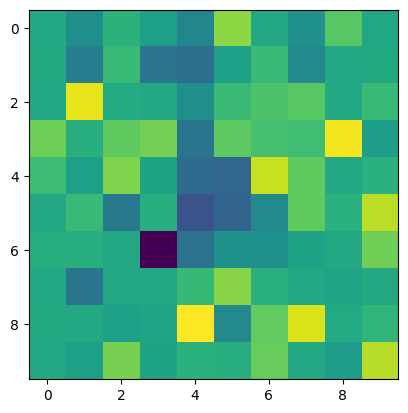

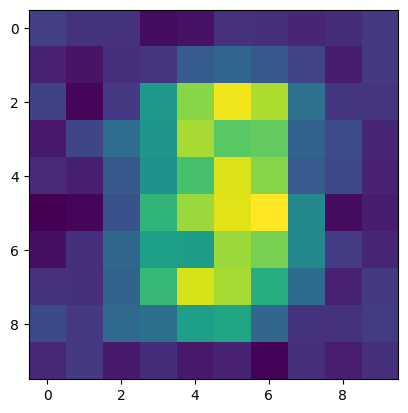

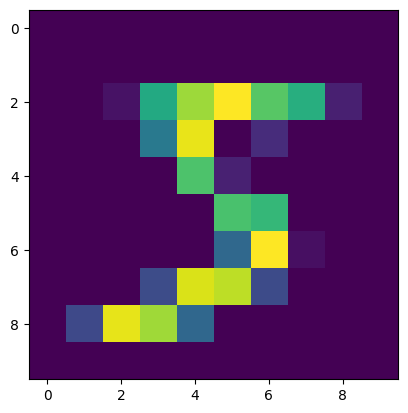

In [23]:
# random input looks like this
z_random = np.random.normal(size=(1,10))
test_z = decoder(z_random) #test_z is a tf 
print(test_z.shape)

show_z = tf.reshape(test_z, (1,10,10))
print(show_z.shape)

im_z = tf.math.imag(show_z)

plt.figure()
plt.imshow(im_z[0])

# an encoded digit looks like this
x_testing = tf.reshape(x_train_cx_small[0], [1,-1])
print(x_testing.shape)
y = encoder(x_testing)

x_recon = decoder(y)
im_x = tf.math.imag(tf.reshape(x_recon, (1,10,10)))

plt.figure()
plt.imshow(im_x[0])

plt.figure()
plt.imshow(tf.math.imag(tf.reshape(x_testing, (1,10,10)))[0])

In [ ]:
# compute function generative map
def make_tensor_shape(z):
    #z = z.reshape((1,-1))
    tensor_z = tf.convert_to_tensor(z, dtype=tf.complex64)
    return tf.reshape(tensor_z,[1,-1])

def make_tensor(z):
    return tf.convert_to_tensor(z, dtype=tf.complex64)

# wrapper for decoder to numpy function
def decoderfunc_1D(z, decoder):
    '''
    Converts the autoencoder.decoder function into a generative embedding function. Note that the tf decoder also returns flattened images.

    input:
        z:              np.array of length (latent_dim)
        decoder:        custom class autosetup.ComplexDecoder, numpy.array(sample size, latent_dim) --> tensor(sample size, dim^2))    

    output:
        decoderfunc_1D: function that maps z to numpy array of lenght dim^2 (flattened original image)
    '''
    return decoder(tf.reshape(make_tensor(z), [1,-1])).numpy()

# wrapper for Jacobian computation to numpy function
def jac_decoder_1D(z, decoder):
    '''
    Converts the CBP_decoder computation into a numpy function, outputting the R-derivative of the decoder in z as a numpy array
    NOTE: activation function is hardcoded at this point

    input:
        z:              np.array of length (latent_dim)
        decoder:        custom class autosetup.ComplexDecoder, numpy.array(sample size, latent_dim) --> tensor(sample size, dim^2))
    '''
    dG_dz, _ = CBP_decoder(tf.reshape(make_tensor(z), [1,-1]), decoder, autosetup.Jac_modrelu)
    return dG_dz.numpy()

### Integrate with least squares signal optimization

In [28]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape
        
def objective(z, y, A, G, w=1, lmbda = 0):
    """
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    """
    if len(y) != A.shape[0]:
        print("y and A don't match")
        return
    if len(z)//2 != G.shape[1]:
        print("z and G don't match")
        return
    if A.shape[1] != G.shape[0]:
        print("A and G don't match!")
        return
    
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]
    
    xc = G.eval(zc)
    Dx = G.jac(zc)

    #print("Dx", Dx.shape)
    
    yp = A.eval(xc)
    Dy = A.jac(xc)

    #print("Dy", Dy.shape)

    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    gradc  = Dx.H@(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc
    
    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))
    
    return val, grad

def reconstruct(xtrue, A, G, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    print("xtrue", xtrue.shape)
    print("yobs", yobs.shape)
    print("k", k)
    print("m", m)

    # inference
    result = minimize(objective, x0=np.ones(2*k), args=(yobs, A, G, w, lmbda), method='L-BFGS-B', jac=True)
    
    # result
    zhat = result.x[:k] + 1j*result.x[k:]
    xhat = G.eval(zhat)
    
    # correct global phase
    phi = np.mean(np.angle(xtrue/xhat))
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, xhat_corr, yobs

def plot_result(xtrue, xhat):
    n  = len(xtrue)
    nx = int(np.sqrt(n))
    
    # plot results
    fig, ax = plt.subplots(2,2)

    ax[0,0].imshow(np.real(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[0,0].set_title(r'$\Re(x_{true})$')
    ax[1,0].imshow(np.imag(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[1,0].set_title(r'$\Im(x_{true})$')
    ax[0,1].imshow(np.real(xhat.reshape((nx,nx))),clim=[0,1])
    ax[0,1].set_title(r'$\Re(x_{est})$')
    ax[1,1].imshow(np.imag(xhat.reshape((nx,nx))),clim=[0,1])
    ax[1,1].set_title(r'$\Im(x_{est})$')

    fig.tight_layout()

In [14]:
def MaskedFourier(M):
    """
    Defined masked 2D fourier transform as linear operator.
    
    input:
        M - 3D array of size n x n x m containing m masks of size n x n
        
    out:
        A - linear operator representing the masked Fourier transforms
        
    
    """
    nx = M.shape[0]
    mx = M.shape[2]
    
    mv  = lambda x : fft2(M*(x.reshape((nx,nx,1))), axes=(0,1)).flatten()
    rmv = lambda y : nx*nx*np.sum(np.conj(M)*ifft2(y.reshape((nx,nx,mx)), axes=(0,1)),axis=2).flatten()
    A   = LinearOperator((mx*nx*nx, nx*nx), matvec=mv, rmatvec=rmv) # rmatvec is conjugate operation, so A^H * v
    
    return A

In [15]:
# parameters
mx      = 10       # number of masks
nx      = shape[0]  # one side of the image
n       = nx**2     # total length of one image

In [16]:
# define forward operator with binary masks
m  = mx * n

M = np.random.randn(nx,nx,mx)
M[M<0]=0
M[M>0]=1

MF   = MaskedFourier(M)
print(MF.shape)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))

A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

(1000, 100)


In [26]:
# get prior from decoder
k               = latent_dim
compute_jac     = jac_decoder_1D(autoencoder.decoder, latent_dim)
block_identity  = lambda mat : np.concatenate((mat, np.eye(n)), axis=1)


#define generative models
I = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))

G = Op(fun = lambda z : decoderfunc_1D(autoencoder.decoder, z), 
       jac = lambda z : LinearOperator((n,k), matvec = lambda v : compute_jac(z) @ v, rmatvec = lambda v : np.conj(compute_jac(z).T) @ v),
       shape = (n,k))

H = Op(fun = lambda z : decoderfunc_1D(autoencoder.decoder, z[:k]) + z[k:], 
       jac = lambda z : LinearOperator((n,k+n), matvec = lambda v : block_identity(compute_jac(z[:k])) @ v, rmatvec = lambda v : np.conj(block_identity(compute_jac(z[:k])).T) @ v),
       shape = (n,k+n))

# G = Op(fun = lambda z : decoderfunc_1D(autoencoder.decoder, z), 
#        jac = lambda z: (
#                 lambda grads: LinearOperator(
#                     (n, k),
#                     matvec=lambda v: grads @ v,
#                     rmatvec=lambda v: np.conj(grads.T) @ v
#                 )
#             )(decoderfun_1D(make_tensor_shape(z))[1].numpy()), 
#         shape = (n,k))

# H = Op(fun = lambda z : (decoderfun_1D(make_tensor_shape(z[:,:k]))[0].numpy() + z[:,k:]).flatten(), 
#        jac = lambda z: (
#                 lambda grads: LinearOperator(
#                     (n, k+n),
#                     matvec=lambda v: grads @ v,
#                     rmatvec=lambda v: np.conj(grads.T) @ v
#                 )
#             )(np.concatenate((decoderfun_1D(make_tensor_shape(z[:,:k]))[1].numpy()[0], np.eye(n)), axis=1)),  
#         shape=(n, k+n))


#G = Op(fun = lambda z : decoderfun_1D(make_tensor(z))[0].numpy(),  
       #jac = lambda z : LinearOperator((n, k), matvec = lambda x : decoderfun_1D(make_tensor(z))[1].numpy()@x, rmatvec = lambda y : np.conj(decoderfun_1D(make_tensor(z))[1].numpy().T)@y), shape=(n,k))
#H = Op(fun = lambda z : mu + C@z, jac = lambda z : LinearOperator((n, k+n), matvec = lambda z : C@z, rmatvec = lambda z : np.conj(C.T)@z), shape=(n,k+n))

# define weights
w = 1

# test
z_testing = np.ones(10)
x_testing = np.ones(100)
y_testing = np.ones((1000))
h_testing = np.ones((110))

G_jac = G.jac(z_testing)
G_H = G_jac.H

print(G_jac.shape)
print(G_H.shape)

print(type(G_jac))
print(type(G_H))

G_jac@z_testing
print((G_jac@z_testing).shape)

H_test = block_identity(compute_jac(z_testing))

print(H_test.shape)

H_func = H.eval(h_testing)
H_jac = H.jac(h_testing)
H_H = H_jac.H

print(H_func.shape)
print(H_jac.shape)
print(H_H.shape)


(100, 10)
(10, 100)
<class 'scipy.sparse.linalg._interface._CustomLinearOperator'>
<class 'scipy.sparse.linalg._interface._CustomLinearOperator'>
(100,)
(100, 110)
(100,)
(100, 110)
(110, 100)


(10000, 64)
(1, 64)
(1, 784)
(1, 28, 28)


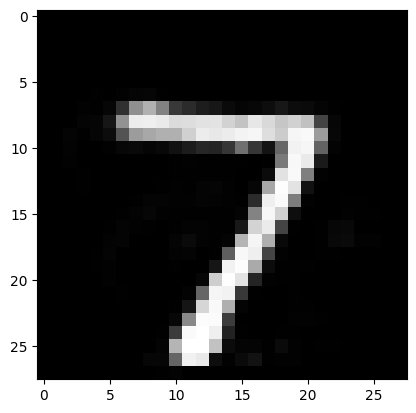

In [ ]:
# test going from 1D to 2D
encoded_imgs = autoencoder.encoder(x_test).numpy()
print(encoded_imgs.shape)

one_test_img = np.zeros((1,latent_dim))
one_test_img[0,:] = encoded_imgs[0,:]
print(one_test_img.shape)

test_G = G.eval(one_test_img)
print(test_G.shape)
restored = test_G.reshape((1,nx,nx))
print(restored.shape)

plt.figure()
plt.imshow(restored[0])


In [279]:
xtrue = x_test_small[0].numpy()
xtrue_1D = xtrue.reshape((1, -1))
print(xtrue.shape)

(10, 10)


In [284]:
z = np.ones(k)
w = 1
lmbda = 0
sigma = 0

xtrue = x_test_small[0].numpy()
xtrue_1D = xtrue.flatten()

y = A.eval(xtrue_1D) + sigma*np.random.randn(m)

#k  = len(z)//2
#zc = z[:k] + 1j*z[k:]

#print("zc", zc.shape)

print("y", y.shape)

xc = G.eval(z)
Dx = G.jac(z)

print("xc", xc.shape)
print("Dx", Dx.shape)
    
yp = A.eval(xc)
Dy = A.jac(xc)

print("yp", yp.shape)
print("Dy", Dy.shape)

val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2    
gradc  = Dx.H@(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*z

print("gradc", gradc.shape)
    
grad  = np.concatenate((np.real(gradc), np.imag(gradc)))

print("grad", grad.shape)

y (1000,)
xc (100,)
Dx (100, 10)
yp (1000,)
Dy (1000, 100)
gradc (10,)
grad (20,)


(100,)
xtrue (100,)
yobs (1000,)
k 110
m 1000


c:\Users\Abel\miniconda3\envs\wtf\lib\site-packages\tensorflow\python\framework\constant_op.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


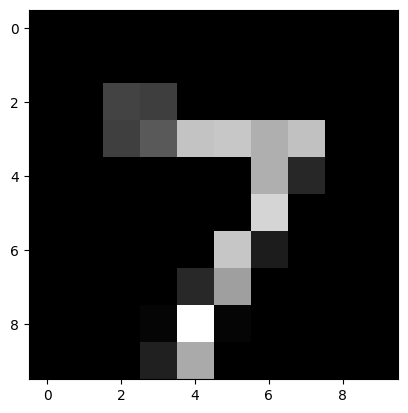

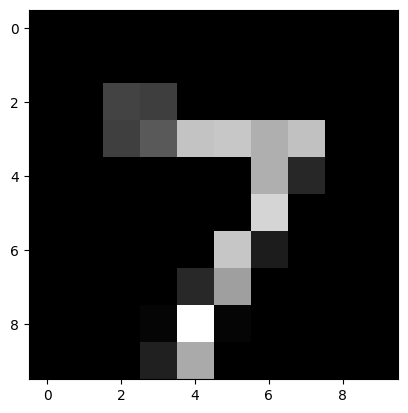

In [29]:
# test with l2
xtrue = x_test_small[0].numpy()
plt.figure()
plt.imshow(xtrue)

xtrue_1D = xtrue.flatten()
print(xtrue_1D.shape)

error, xhat_corr, yobs = reconstruct(xtrue_1D, A, H, w=1, sigma=0, lmbda=0)

xhat_corr = xhat_corr.reshape((nx,nx))

plt.figure()
plt.imshow(np.real(xhat_corr))